In [74]:
import random
random.seed(111)
import numpy as np
from tqdm import tqdm
# let's imagine, we know portion of tokens that are useless in training
p = 0.2

# we have total N samples in the training dataset, and sample length is L tokens
N = 1000
L = 1000

# on each epoch, we have a change to mask the token which is not useful
# we need to estimate this chance

def count_useless_tokens(epoch, sample_length_token, probability_of_useless_token, masking_probability,
							max_seq_len, min_seq_len):
	sample_token_ids = np.arange(sample_length_token)
	bad_tokens = set([i for i in range(sample_length_token) if random.random() < probability_of_useless_token])
	known_bad_tokens = set()
	for e in range(epoch):
		_max_seq_len = random.randint(min_seq_len, max_seq_len)
		st_index = random.randint(0, sample_length_token // 2)
		subsample = sample_token_ids[st_index:st_index + _max_seq_len]
		subsample = [i for i in subsample if random.random() < masking_probability]
		# add bad tokens that are in the subsample to the known bad tokens set
		known_bad_tokens.update([i for i in subsample if i in bad_tokens])
		
	max_seq_len = random.randint(min_seq_len, max_seq_len)
	st_index = random.randint(0, sample_length_token // 2)
	subsample = sample_token_ids[st_index:st_index + max_seq_len]
	sampled_unknown_bad_tokens = set([i for i in subsample if i in bad_tokens]) - known_bad_tokens
	return len(sampled_unknown_bad_tokens) / len(subsample)



In [75]:
count_useless_tokens(2, 
											 sample_length_token=36000//9, 
											 probability_of_useless_token=0.25, 
											 masking_probability=0.3,
											 max_seq_len=1024, 
											 min_seq_len=10)

0.23529411764705882

In [77]:
# To estimate probability of 'bad' tokens in the dataset, we can use the following command:
# awk '{count[$4]++} END {for (num in count) print num, count[num]}' human.100samples_is_true.bedGraph
# 0 312816
# 1 49952
# 49952/(49952+312816) ~ 0.14

results = {}
N_epochs = 30
probability_of_useless_token = 0.25
for epoch in tqdm(range(N_epochs)):
	if epoch not in results:
		results[epoch] = []
	for sample in range(1000):
		results[epoch].append(count_useless_tokens(epoch, 
											 sample_length_token=36000//9, 
											 probability_of_useless_token=0.25, 
											 masking_probability=0.3,
											 max_seq_len=1024, 
											 min_seq_len=10)
							)

100%|██████████| 30/30 [00:39<00:00,  1.32s/it]


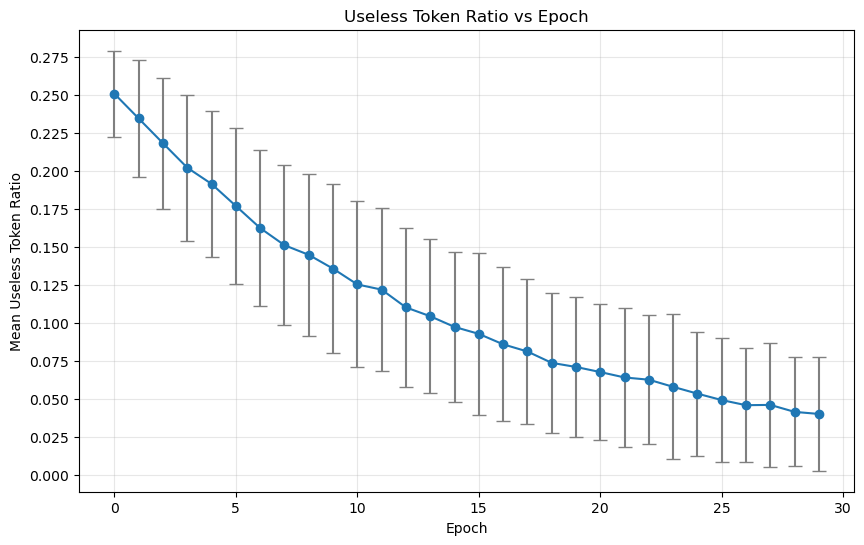

In [81]:
import matplotlib.pyplot as plt

# Calculate means and standard errors for each epoch
means = [np.mean(results[epoch]) for epoch in range(N_epochs)]
stds = [np.std(results[epoch]) for epoch in range(N_epochs)]

# Create the plot
plt.figure(figsize=(10, 6))
plt.errorbar(range(N_epochs), means, yerr=stds, fmt='o-', capsize=5, capthick=1, ecolor='gray')

# Customize the plot
plt.xlabel('Epoch')
plt.ylabel('Mean Useless Token Ratio')
plt.title('Useless Token Ratio vs Epoch')
plt.grid(True, alpha=0.3)

# Add more frequent y-ticks
ticks = np.arange(0, max(means) + 0.025, 0.025)
plt.yticks(ticks)

# Show the plot
plt.show()

In [22]:
# 49952/(49952+312816)

0.13769682000617475

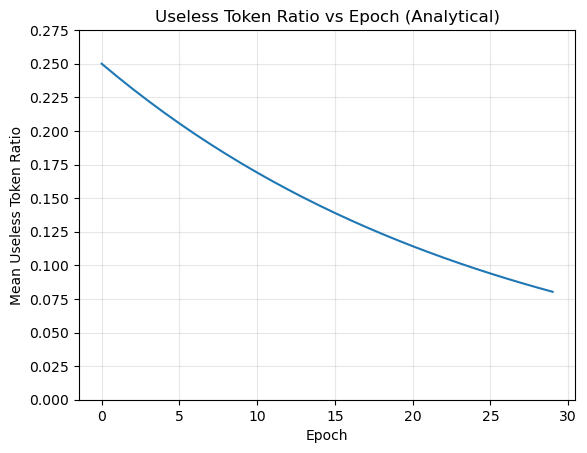

In [82]:
prob_to_see_token = (512/4000)*0.3
Y = []
for n in range(N_epochs):
	Y.append(
		probability_of_useless_token*(
			(1-prob_to_see_token)**n
		)
	)

plt.plot(range(N_epochs), Y)

# Customize the plot
plt.xlabel('Epoch')
plt.ylabel('Mean Useless Token Ratio')
plt.title('Useless Token Ratio vs Epoch (Analytical)')
plt.grid(True, alpha=0.3)

# Add more frequent y-ticks
plt.yticks(ticks)

plt.show()


In [ ]:
# 